# Hypothesis Testing

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats


merged_df = pd.read_csv("merged_earthquake_rent.csv")

## H1 - Earthquake Risk vs Rent:

**Null Hypothesis (H0):** District and neighborhood-level earthquake risk indicators (e.g., damage_ratio, casualty_ratio, earthquake_risk_index) have no relationship with rental prices per m². In particular, the average rent per m² does not differ between low-risk and high-risk neighborhoods.

**Alternative Hypothesis (H1):** Districts and neighborhoods with higher earthquake risk have lower rental prices per m², i.e., earthquake risk is negatively associated with rent levels.

To test this hypothesis, I use:
	1.	Pearson correlation between the continuous earthquake_risk_index and log-transformed price per m²;
	2.	An independent-samples t-test comparing low-risk vs high-risk neighborhoods in terms of average log(price_per_m2).

This combination allows me to see both the overall linear association and the mean difference between clearly separated risk groups.

### Data Preparation for H1
In this section, I reuse the merged dataset constructed during the EDA phase. I focus on:
	price_per_m2 as the main outcome,
	earthquake_risk_index as the main risk indicator,
	risk_level (low / medium / high).

In [93]:

ht_df = merged_df.copy()
ht_df = ht_df[ht_df["price_per_m2"] > 0].copy()

# Log-transform price_per_m2 to reduce skewness
ht_df["log_price_per_m2"] = np.log(ht_df["price_per_m2"])

# Remove extreme outliers in price_per_m2 for robustness
upper_price_cut = ht_df["price_per_m2"].quantile(0.99)
ht_df = ht_df[ht_df["price_per_m2"] <= upper_price_cut].copy()


# Create risk_level categories (low / medium / high) 
ht_df["risk_level"] = pd.qcut(
    ht_df["earthquake_risk_index"],
    3,
    labels=["low", "medium", "high"]
)

ht_df["risk_level"].value_counts()

risk_level
low       3749
high      3687
medium    3628
Name: count, dtype: int64

### Exploratory Visualization for H1
Before running statistical tests, I visualize how rent per m² behaves across risk levels and over the continuous risk index.
	1.	Boxplot of price_per_m2 by risk_level (low / medium / high).
	2.	Scatterplot of earthquake_risk_index vs log_price_per_m2, with a fitted regression line.

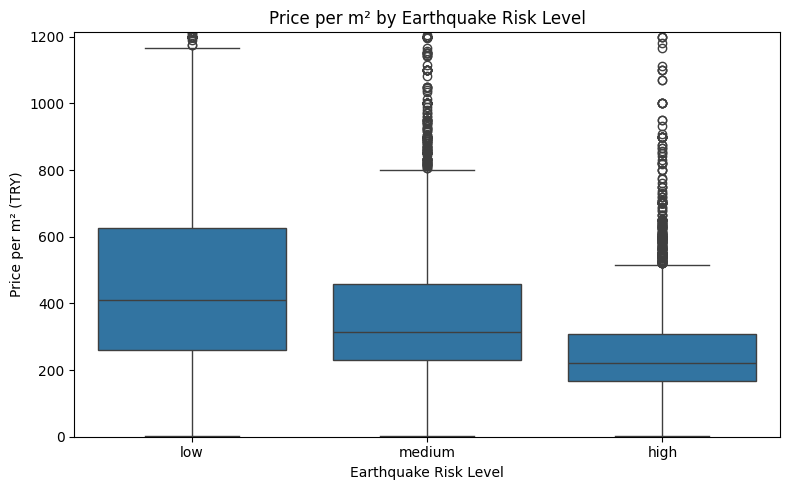

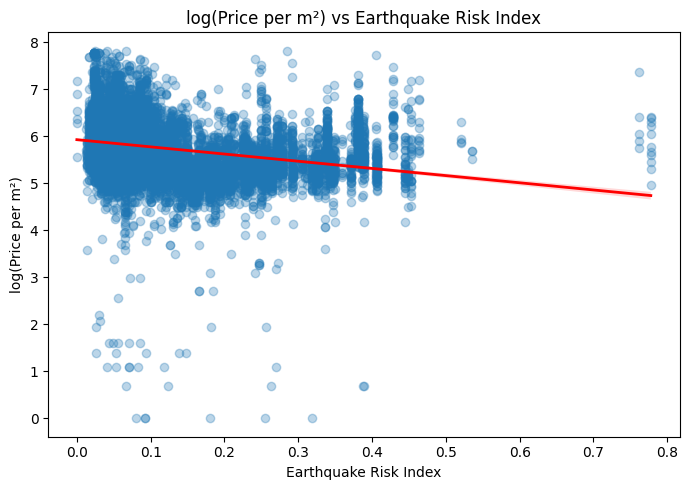

In [32]:
#  Boxplot: Price per m² by Risk Level
plt.figure(figsize=(8,5))
sns.boxplot(
    data=ht_df,
    x="risk_level",
    y="price_per_m2",
    order=["low", "medium", "high"]
)
plt.title("Price per m² by Earthquake Risk Level")
plt.xlabel("Earthquake Risk Level")
plt.ylabel("Price per m² (TRY)")
plt.ylim(0, ht_df["price_per_m2"].quantile(0.98))  
plt.tight_layout()
plt.show()

# Scatter: Risk Index vs log(Price per m²) 
plt.figure(figsize=(7,5))
sns.regplot(
    data=ht_df,
    x="earthquake_risk_index",
    y="log_price_per_m2",
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "red", "linewidth": 2}
)

plt.title("log(Price per m²) vs Earthquake Risk Index")
plt.xlabel("Earthquake Risk Index")
plt.ylabel("log(Price per m²)")
plt.tight_layout()
plt.show()

### Statistical Tests for H1

#### Pearson Correlation: Risk Index vs log(Price per m²)

In [33]:
corr_df = ht_df.dropna(subset=["earthquake_risk_index", "log_price_per_m2"])

r, p_value = stats.pearsonr(
    corr_df["earthquake_risk_index"],
    corr_df["log_price_per_m2"]
)
n = corr_df.shape[0]
dfree = n - 2

print(f"Pearson correlation (r) between risk index and log(price_per_m2): {r:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Sample size (n): {n}, Degrees of freedom: {dfree}")

Pearson correlation (r) between risk index and log(price_per_m2): -0.2457
p-value: 8.5127e-152
Sample size (n): 11064, Degrees of freedom: 11062


#### Two-Sample t-Test: Low vs High Risk Neighborhoods

In [34]:
# Select low-risk and high-risk groups
low_group  = ht_df[ht_df["risk_level"] == "low"]["log_price_per_m2"]
high_group = ht_df[ht_df["risk_level"] == "high"]["log_price_per_m2"]

print("Group sizes:", len(low_group), "low risk,", len(high_group), "high risk")

# Welch's t-test (unequal variances)
t_stat, p_val_t = stats.ttest_ind(
    low_group,
    high_group,
    equal_var=False
)

mean_low  = low_group.mean()
mean_high = high_group.mean()

print(f"Mean log(price_per_m2) - low risk:  {mean_low:.4f}")
print(f"Mean log(price_per_m2) - high risk: {mean_high:.4f}")
print(f"Difference (low - high): {mean_low - mean_high:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value (two-sided): {p_val_t:.4e}")

Group sizes: 3749 low risk, 3687 high risk
Mean log(price_per_m2) - low risk:  6.0139
Mean log(price_per_m2) - high risk: 5.4371
Difference (low - high): 0.5769
t-statistic: 40.9728
p-value (two-sided): 0.0000e+00


### Interpretation of H1 Results

The Pearson correlation (r ≈ –0.25) shows a moderate but statistically significant linear relationship between the earthquake risk index and log(price per m²). The p-value (~8.5e-152) is far below the significance level of α = 0.05, so we reject the null hypothesis.

Similarly, the Welch t-test comparing low-risk and high-risk neighborhoods shows a very large difference in mean log(price per m²) (0.5769). The two-sided p-value is effectively zero, again well below α = 0.05. This confirms that average rent per m² is significantly higher in low-risk neighborhoods.

Overall, both tests indicate that earthquake risk is statistically associated with rental prices in Istanbul. Even though the strength of the relationship is moderate, higher-risk neighborhoods consistently show lower rent levels, so we reject the null hypothesis.

## H2 - Building Age vs Earthquake Risk Interaction:

**Null Hypothesis (H0):** The relationship between building age and rental price per m² does not change across earthquake risk levels. In other words, the effect of age on rent is the same in low-risk and high-risk neighborhoods.

**Alternative Hypothesis (H2):** The negative effect of building age on rental price per m² is stronger in high-risk neighborhoods, meaning older buildings lose more rental value where earthquake risk is higher.

This hypothesis tests whether the age → price_per_m2 relationship becomes steeper (more negative) in high-risk areas compared to low-risk areas.

### Data Preparation for H2

In this step, I filter the dataset to include only low-risk and high-risk neighborhoods. These groups were defined earlier using the earthquake risk index.

In [68]:

# Select only low and high risk groups
h2_df = ht_df[ht_df["risk_level"].isin(["low", "high"])].copy()

low_df  = h2_df[h2_df["risk_level"] == "low"].copy()
high_df = h2_df[h2_df["risk_level"] == "high"].copy()

### Exploratory Visualization for H2

To understand how building age relates to rental prices across different risk levels, I compute the average price per m² in age bins and plot two clean lines:
- Blue line: low-risk neighborhoods
- Red line: high-risk neighborhoods

/var/folders/8j/241xzjys27lgf4trblbqkwdc0000gn/T/ipykernel_73712/2115409668.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  h2_df.groupby(["age_bin", "risk_level"])["price_per_m2"]


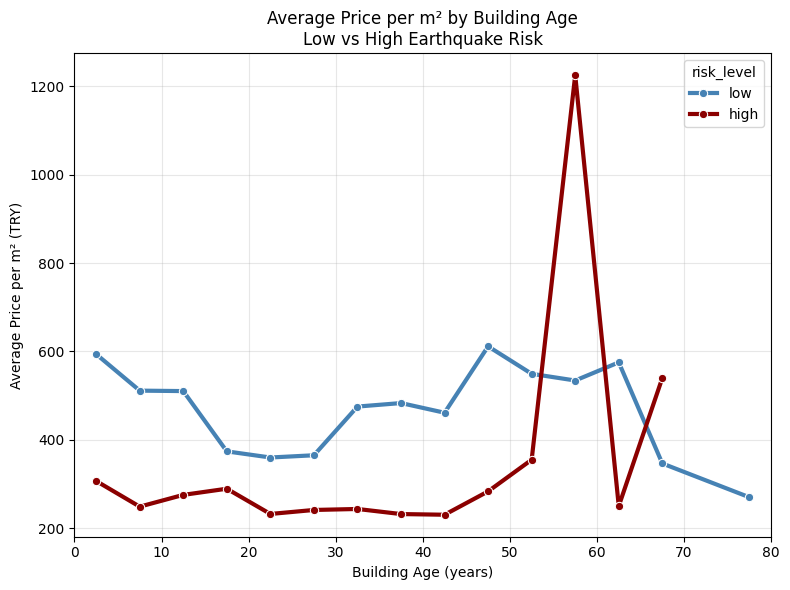

In [62]:

if str(h2_df["risk_level"].dtype).startswith("category"):
    h2_df["risk_level"] = h2_df["risk_level"].cat.remove_unused_categories()
else:
    h2_df["risk_level"] = h2_df["risk_level"].astype(str)

bins = np.arange(0, 85, 5)
h2_df["age_bin"] = pd.cut(h2_df["age"], bins=bins)

# Compute average price per m2 by age group + risk group
binned = (
    h2_df.groupby(["age_bin", "risk_level"])["price_per_m2"]
    .mean()
    .reset_index()
)

binned["age_mid"] = binned["age_bin"].apply(lambda x: x.mid)

plt.figure(figsize=(8,6))

sns.lineplot(
    data=binned,
    x="age_mid",
    y="price_per_m2",
    hue="risk_level",
    palette={"low": "steelblue", "high": "darkred"},
    linewidth=3,
    marker="o"
)

plt.title("Average Price per m² by Building Age\nLow vs High Earthquake Risk")
plt.xlabel("Building Age (years)")
plt.ylabel("Average Price per m² (TRY)")
plt.grid(alpha=0.3)
plt.xlim(0, 80)
plt.tight_layout()
plt.show()

### Statistical Test for H2

#### Simple Linear Regression

To compare the effect of age on rent between the two risk groups, I fit a simple linear regression separately for low- and high-risk neighborhoods.


In [95]:

def simple_regression(df):
    X = sm.add_constant(df["age"])
    y = df["price_per_m2"]
    model = sm.OLS(y, X).fit()
    slope = model.params["age"]
    pval  = model.pvalues["age"]
    return slope, pval

slope_low, p_low = simple_regression(low_df)
slope_high, p_high = simple_regression(high_df)

print("Low-risk slope:", slope_low)
print("Low-risk p-value:", p_low)
print("High-risk slope:", slope_high)
print("High-risk p-value:", p_high)

Low-risk slope: -4.66946084069386
Low-risk p-value: 1.0709034457243382e-27
High-risk slope: -1.1970428527359984
High-risk p-value: 5.602215061901673e-13


### Interpretation of H2 Results

Regressions show that building age has a negative and statistically significant effect on rental price per m² (p-values far below α = 0.05). This means that older buildings are cheaper on average, regardless of risk level.

However, the magnitude of the age effect differs across risk groups:
- In low-risk neighborhoods, each additional year of age reduces rental price by about –4.67 TRY per m².
- In high-risk neighborhoods, the reduction is about –1.20 TRY per m² per year.

Since the negative age effect is larger in low-risk areas, the results do not support the alternative hypothesis (H2). Instead, age appears to penalize rents more strongly in low-risk neighborhoods than in high-risk ones.

Because the high-risk slope is not more negative than the low-risk slope, the evidence does not support H2. Therefore, we fail to reject the null hypothesis (H0).

## H3 - Floor Level vs Earthquake Risk Interaction: 

**Null Hypothesis (H0):** The relationship between floor level and rental price per m² does not change across earthquake risk levels. In other words, the effect of floor level on rent is the same in low-risk and high-risk neighborhoods.

**Alternative Hypothesis (H3):** The negative effect of floor level on rental price per m² is stronger in high-risk neighborhoods. This means higher-floor apartments lose more value where earthquake risk is high.

This hypothesis examines whether floor level (height) becomes a more important factor in shaping rental prices when seismic risk is higher.

### Data Preparation for H3

In this step, I filter the dataset to include only low-risk and high-risk neighborhoods. These groups were defined earlier using the earthquake risk index.

In [70]:
h3_df = ht_df[ht_df["risk_level"].isin(["low", "high"])].copy()

low_f_df  = h3_df[h3_df["risk_level"] == "low"].copy()
high_f_df = h3_df[h3_df["risk_level"] == "high"].copy()

### Exploratory Visualization for H3

To observe how floor level relates to price per m² across risk groups, I compute average values in binned floor ranges.

/var/folders/8j/241xzjys27lgf4trblbqkwdc0000gn/T/ipykernel_73712/1478665234.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  h3_df.groupby(["floor_bin", "risk_level"])["price_per_m2"]


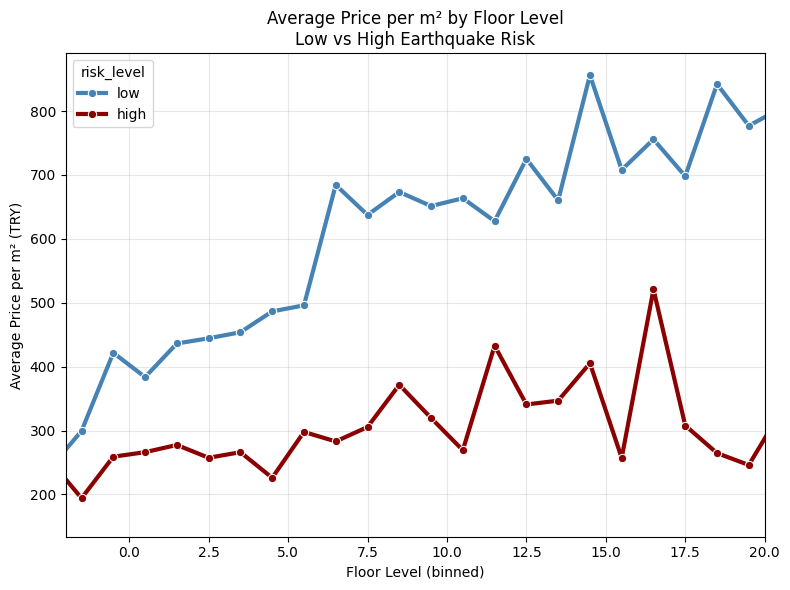

In [75]:

if str(h3_df["risk_level"].dtype).startswith("category"):
    h3_df["risk_level"] = h3_df["risk_level"].cat.remove_unused_categories()
else:
    h3_df["risk_level"] = h3_df["risk_level"].astype(str)

# Bin by floor
bins = np.arange(-4, 25, 1)
h3_df["floor_bin"] = pd.cut(h3_df["floor"], bins=bins)

# Average price per m2 by floor level + risk level
binned_f = (
    h3_df.groupby(["floor_bin", "risk_level"])["price_per_m2"]
    .mean()
    .reset_index()
)

binned_f["floor_mid"] = binned_f["floor_bin"].apply(lambda x: x.mid)

plt.figure(figsize=(8,6))

sns.lineplot(
    data=binned_f,
    x="floor_mid",
    y="price_per_m2",
    hue="risk_level",
    palette=["steelblue", "darkred"],
    linewidth=3,
    marker="o"
)

plt.title("Average Price per m² by Floor Level\nLow vs High Earthquake Risk")
plt.xlabel("Floor Level (binned)")
plt.ylabel("Average Price per m² (TRY)")
plt.grid(alpha=0.3)
plt.xlim(-2, 20)
plt.tight_layout()
plt.show()

### Statistical Test for H3

#### Simple Linear Regression

To compare the effect of floor level on rent between the two risk groups, I fit a simple linear regression separately for low- and high-risk neighborhoods.

In [96]:

def simple_regression(df):
    X = sm.add_constant(df["floor"])
    y = df["price_per_m2"]
    model = sm.OLS(y, X).fit()
    slope = model.params["floor"]
    pval  = model.pvalues["floor"]
    return slope, pval

slope_low_f, p_low_f = simple_regression(low_f_df)
slope_high_f, p_high_f = simple_regression(high_f_df)

print("Low-risk slope:", slope_low_f)
print("Low-risk p-value:", p_low_f)
print("High-risk slope:", slope_high_f)
print("High-risk p-value:", p_high_f)

Low-risk slope: 21.245672866433704
Low-risk p-value: 1.0886308557644324e-122
High-risk slope: 4.565398075186777
High-risk p-value: 4.8578305153432714e-08


### Interpretation of H3 Results

The simple linear regression results indicate that floor level has a statistically significant positive effect on rental prices in both low-risk and high-risk neighborhoods. In low-risk areas, the effect is much stronger: the slope is 21.25, meaning each additional floor level increases price per m² by about 21.3 TRY. In high-risk neighborhoods, the effect remains positive but is noticeably smaller, with a slope of 4.57 TRY per m². Both p-values are far below the significance level of α = 0.05, so the floor effect is statistically significant in both groups.

Because the positive impact of floor level on rental prices is substantially weaker in high-risk neighborhoods, we reject the null hypothesis (H0). 